Validation on kmeans

### Think through  how to better handle indexing and merging pd_df challenges

This notebook validates using the 60% validation Koumassi dataset (n=604 points)

This is a working notebook to label 8 cluster kmeans result. The labeled map is sampled using the 60% subset of validation samples to identify characteristics of each class (floodwater, shadow, other)

Currently working on trying to separate flood and shadow areas based on perimeter and area characteristics.

In [1]:
# Import packages
import os, sys
import numpy as np
import geopandas as gpd
from matplotlib import pyplot as plt
import pandas as pd
from glob import glob
import rasterio as rio
import earthpy.spatial as es
import earthpy.plot as ep
import earthpy as et
from skimage import measure
from skimage import morphology
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

%matplotlib inline

In [2]:
# Set working directory
# os.chdir(os.path.join(et.io.HOME, 'earth-analytics','spring-2019', 'flood-detection'))
os.environ["PROJ_LIB"] = r"C:\Users\katy\Anaconda3\envs\earth-analytics-python\Library\share"

In [3]:
# Set directory to area of interest containing raster stack
aoi = "koumassi_focus_ps"
kmeans_file ="kmeans_with_shadow_mask"
band_path = '..\\data\\'+aoi+"\\"
raster_outputs_path = os.path.join(band_path, "outputs\\raster_files\\")
kmeans_outputs_path = os.path.join(band_path, "outputs\\kmeans\\")
kmeans_path = os.path.join(band_path, "outputs\\kmeans\\"+kmeans_file+".tif")

# Open existing raster stack
# band_path = os.path.join("dg-data", aoi +"\\")
# band_stack_path = os.path.join(band_path, "outputs\\indices_and_mask_files\\")
# all_bands_path = os.path.join(band_stack_path, aoi + "_all_bands.tif")
# outputs_path = os.path.join("dg-data", aoi ,"outputs", "raster_files\\")
# kmeans_path = outputs_path+"kmeans_koumassi_focus_ps.tif"
# kmeans_path = outputs_path+"kmeans_with_shadow_mask.tif"
# cluster_path = os.path.join("dg-data",aoi,"outputs","clustering","kmeans")
# validation_data_path = os.path.join("validation")
# valid_data = pd.read_csv(valid_data_path+"\\"+"koumassi_validation_data_60_percent.csv")
# sample_pts_path = os.path.join("validation","vector-data")
# sample_pts = gpd.read_file(sample_pts_path+"\\"+"validation_points_koumassi_60_percent.shp")

validation_data_path = os.path.join(band_path,'validation\\')
sample_pts_60perc = gpd.read_file(validation_data_path+"vector-data\\validation_points_koumassi_60_percent.shp")
sample_pts_40perc = gpd.read_file(validation_data_path+"vector-data\\validation_points_koumassi_40_percent.shp")
sample_pts_all = gpd.read_file(validation_data_path+"vector-data\\"+"all_koumassi_validation_points.shp")

valid_60_data = pd.read_csv(validation_data_path+"koumassi_validation_data_60_percent.csv")
valid_40_data = pd.read_csv(validation_data_path+"koumassi_validation_data_40_percent.csv")
all_valid_data = pd.read_csv(validation_data_path+"all_koumassi_validation_data.csv")

In [4]:
# Update these based on looking at what each cluster represents
class8 = 2
class7 = 3 # used 1 here for shadow_build
class6 = 3
class5 = 1
class4 = 3
class3 = 1 # see what validates better 1 or 2
class2 = 3 # choose 1 or 2 for 010
class1 = 3

In [5]:
valid_60_data.head()

,OBJECTID,ClassValue
0,1,2
1,2,1
2,3,1
3,4,1
4,5,1


## Validating on 60% of data

In [6]:
# Create tuples of all x coordinates and y coordinates 
x_coords = tuple(sample_pts_60perc.geometry.x)
y_coords = tuple(sample_pts_60perc.geometry.y)
# Use rasterio sample method to pull label numbers for 60% reference dataset. 
# kmeans_labeled_path = kmeans_outputs_path+kmeans_file+'_labeled.tif'
# Sample from labeled map (kmeans_labels)
sampled_values = []

# Sample raster at each combo of x and y coordinates
with rio.open(kmeans_path) as src:
#     src = np.squeeze(src)
    for val in src.sample(zip(x_coords, y_coords)):
        
        # Note that each val is an individual numpy array
        #print(val.shape)
        sampled_values.append(val)
        
# Convert list to one-dimensional array
arr = np.array([sampled_values]).squeeze()
# print(arr)

# Convert array to dataframe
kmeans_60_df = pd.DataFrame(arr)
# kmeans_60_df.head()

In [7]:
kmeans_valid = pd.concat([valid_60_data,kmeans_60_df], axis=1, sort=False)
kmeans_valid.columns=["OBJECTID","ClassValue","Kmeans_Cluster"]
kmeans_valid.head()

,OBJECTID,ClassValue,Kmeans_Cluster
0,1,2,3.0
1,2,1,5.0
2,3,1,3.0
3,4,1,3.0
4,5,1,5.0


In [8]:
kmeans_valid.loc[kmeans_valid['Kmeans_Cluster'] == 8.0,"new"] = class8
kmeans_valid.loc[kmeans_valid['Kmeans_Cluster'] == 7.0,"new"] = class7
kmeans_valid.loc[kmeans_valid['Kmeans_Cluster'] == 6.0,"new"] = class6
kmeans_valid.loc[kmeans_valid['Kmeans_Cluster'] == 5.0,"new"] = class5
kmeans_valid.loc[kmeans_valid['Kmeans_Cluster'] == 4.0,"new"] = class4
kmeans_valid.loc[kmeans_valid['Kmeans_Cluster'] == 3.0,"new"] = class3
kmeans_valid.loc[kmeans_valid['Kmeans_Cluster'] == 2.0,"new"] = class2
kmeans_valid.loc[kmeans_valid['Kmeans_Cluster'] == 1.0,"new"] = class1
kmeans_valid.head()

,OBJECTID,ClassValue,Kmeans_Cluster,new
0,1,2,3.0,1.0
1,2,1,5.0,1.0
2,3,1,3.0,1.0
3,4,1,3.0,1.0
4,5,1,5.0,1.0


In [9]:
ytest = kmeans_valid['ClassValue']
ypred = kmeans_valid['new']
accuracy_score(ytest, ypred)

0.8311258278145696

[[275  38   0]
 [ 54 102   4]
 [  0   6 125]]


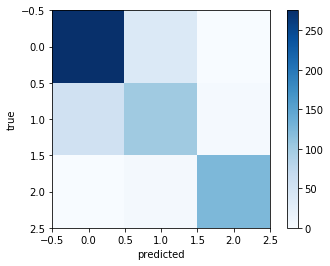

In [10]:
#Print confusion matrix for linear kernel SVM
print(confusion_matrix(ytest, ypred))

plt.imshow(confusion_matrix(ytest, ypred),
           cmap='Blues', interpolation='nearest')
plt.colorbar()
plt.grid(False)
plt.ylabel('true')
plt.xlabel('predicted');

## Validating on 40% of data

In [11]:
# Create tuples of all x coordinates and y coordinates 
x_coords = tuple(sample_pts_40perc.geometry.x)
y_coords = tuple(sample_pts_40perc.geometry.y)
# Use rasterio sample method to pull label numbers for 60% reference dataset. 
# kmeans_labeled_path = kmeans_outputs_path+kmeans_file+'_labeled.tif'
# Sample from labeled map (kmeans_labels)
sampled_values = []

# Sample raster at each combo of x and y coordinates
with rio.open(kmeans_path) as src:
#     src = np.squeeze(src)
    for val in src.sample(zip(x_coords, y_coords)):
        
        # Note that each val is an individual numpy array
        #print(val.shape)
        sampled_values.append(val)
        
# Convert list to one-dimensional array
arr = np.array([sampled_values]).squeeze()
# print(arr)

# Convert array to dataframe
kmeans_40_df = pd.DataFrame(arr)
# kmeans_40_df.head()

In [12]:
kmeans_valid_40 = pd.concat([valid_40_data,kmeans_40_df], axis=1, sort=False)
kmeans_valid_40.columns=["OBJECTID","ClassValue","Kmeans_Cluster"]
kmeans_valid_40.head()

,OBJECTID,ClassValue,Kmeans_Cluster
0,1,2,3.0
1,2,1,3.0
2,3,1,3.0
3,4,1,5.0
4,5,1,5.0


In [13]:
kmeans_valid_40.loc[kmeans_valid_40['Kmeans_Cluster'] == 8.0,"new"] = class8
kmeans_valid_40.loc[kmeans_valid_40['Kmeans_Cluster'] == 7.0,"new"] = class7
kmeans_valid_40.loc[kmeans_valid_40['Kmeans_Cluster'] == 6.0,"new"] = class6
kmeans_valid_40.loc[kmeans_valid_40['Kmeans_Cluster'] == 5.0,"new"] = class5
kmeans_valid_40.loc[kmeans_valid_40['Kmeans_Cluster'] == 4.0,"new"] = class4
kmeans_valid_40.loc[kmeans_valid_40['Kmeans_Cluster'] == 3.0,"new"] = class3
kmeans_valid_40.loc[kmeans_valid_40['Kmeans_Cluster'] == 2.0,"new"] = class2
kmeans_valid_40.loc[kmeans_valid_40['Kmeans_Cluster'] == 1.0,"new"] = class1
kmeans_valid_40.head()

,OBJECTID,ClassValue,Kmeans_Cluster,new
0,1,2,3.0,1.0
1,2,1,3.0,1.0
2,3,1,3.0,1.0
3,4,1,5.0,1.0
4,5,1,5.0,1.0


In [14]:
ytest = kmeans_valid_40['ClassValue']
ypred = kmeans_valid_40['new']
accuracy_score(ytest, ypred)

0.8436724565756824

[[180  29   0]
 [ 32  84   0]
 [  0   2  76]]


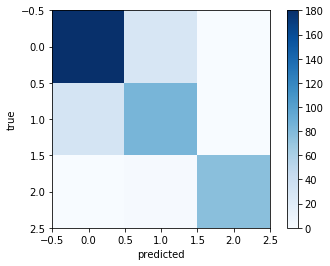

In [15]:
#Print confusion matrix for linear kernel SVM
print(confusion_matrix(ytest, ypred))

plt.imshow(confusion_matrix(ytest, ypred),
           cmap='Blues', interpolation='nearest')
plt.colorbar()
plt.grid(False)
plt.ylabel('true')
plt.xlabel('predicted');

## Validating on complete reference dataset

In [16]:
# Create tuples of all x coordinates and y coordinates 
x_coords = tuple(sample_pts_all.geometry.x)
y_coords = tuple(sample_pts_all.geometry.y)
# Use rasterio sample method to pull label numbers for 60% reference dataset. 
# kmeans_labeled_path = kmeans_outputs_path+kmeans_file+'_labeled.tif'
# Sample from labeled map (kmeans_labels)
sampled_values = []

# Sample raster at each combo of x and y coordinates
with rio.open(kmeans_path) as src:
#     src = np.squeeze(src)
    for val in src.sample(zip(x_coords, y_coords)):
        
        # Note that each val is an individual numpy array
        #print(val.shape)
        sampled_values.append(val)
        
# Convert list to one-dimensional array
arr = np.array([sampled_values]).squeeze()
# print(arr)

# Convert array to dataframe
kmeans_all_df = pd.DataFrame(arr)
kmeans_all_df.head()

,0
0,3.0
1,3.0
2,3.0
3,5.0
4,3.0


In [17]:
kmeans_valid_all = pd.concat([all_valid_data,kmeans_all_df], axis=1, sort=False)
kmeans_valid_all.columns=["OBJECTID","ClassValue","Kmeans_Cluster"]
kmeans_valid_all.head()

,OBJECTID,ClassValue,Kmeans_Cluster
0,1,2,3.0
1,2,2,3.0
2,3,1,3.0
3,4,1,5.0
4,5,1,3.0


In [18]:
kmeans_valid_all.loc[kmeans_valid_all['Kmeans_Cluster'] == 8.0,"new"] = class8
kmeans_valid_all.loc[kmeans_valid_all['Kmeans_Cluster'] == 7.0,"new"] = class7
kmeans_valid_all.loc[kmeans_valid_all['Kmeans_Cluster'] == 6.0,"new"] = class6
kmeans_valid_all.loc[kmeans_valid_all['Kmeans_Cluster'] == 5.0,"new"] = class5
kmeans_valid_all.loc[kmeans_valid_all['Kmeans_Cluster'] == 4.0,"new"] = class4
kmeans_valid_all.loc[kmeans_valid_all['Kmeans_Cluster'] == 3.0,"new"] = class3
kmeans_valid_all.loc[kmeans_valid_all['Kmeans_Cluster'] == 2.0,"new"] = class2
kmeans_valid_all.loc[kmeans_valid_all['Kmeans_Cluster'] == 1.0,"new"] = class1
kmeans_valid_all.head()

,OBJECTID,ClassValue,Kmeans_Cluster,new
0,1,2,3.0,1.0
1,2,2,3.0,1.0
2,3,1,3.0,1.0
3,4,1,5.0,1.0
4,5,1,3.0,1.0


In [19]:
ytest = kmeans_valid_all['ClassValue']
ypred = kmeans_valid_all['new']
accuracy_score(ytest, ypred)

0.8361469712015889

[[455  67   0]
 [ 86 186   4]
 [  0   8 201]]


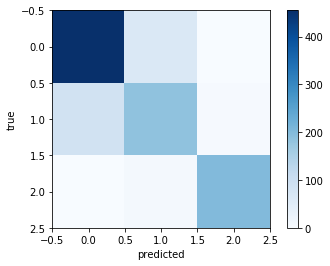

In [20]:
#Print confusion matrix for linear kernel SVM
print(confusion_matrix(ytest, ypred))

plt.imshow(confusion_matrix(ytest, ypred),
           cmap='Blues', interpolation='nearest')
plt.colorbar()
plt.grid(False)
plt.ylabel('true')
plt.xlabel('predicted');